In [95]:
# https://data-analysis-expertise.tistory.com/67

In [96]:
# 업비트 API 설치
!pip install pyupbit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [137]:
# 라이브러리
import pyupbit
import pandas as pd
import time
import numpy as np
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import datetime

# 모듈로 정리

In [ ]:
def make_df(coin_id, interval, count, WINDOW_SIZE, for_periods, TEST_SIZE):
  df = pyupbit.get_ohlcv(ticker='KRW-'+coin_id, interval=interval, to='20220824 00:30:00', count=count)
  WINDOW_SIZE = WINDOW_SIZE
  time_steps = WINDOW_SIZE
  all_data = df
  for_periods = for_periods

  # training & test set 만들기

  ts_train = df[:-TEST_SIZE].values
  ts_test = df[-TEST_SIZE:].values
  ts_train_len = len(ts_train)
  ts_test_len = len(ts_test)

  # training 데이터의 samples와 time steps로 원본데이터 슬라이싱하기
  X_train_full = []
  y_train_full = []
  y_train_stacked = []
  for i in range(time_steps, ts_train_len - 1):
    X_train_full.append(ts_train[i-time_steps:i,0])
    y_train_full.append(ts_train[i:i+for_periods, 0])
  X_train_full, y_train_full = np.array(X_train_full), np.array(y_train_full)

  # scale the data
  from sklearn.preprocessing import MinMaxScaler
  sc = MinMaxScaler()
  sc1 = MinMaxScaler()
  X_train_full_scaled = sc.fit_transform(X_train_full)

  y_train_full_scaled = sc1.fit_transform(y_train_full)
  
  # 3차원으로 재구성하기
  X_train_full_scaled = np.reshape(X_train_full_scaled, (X_train_full_scaled.shape[0], X_train_full_scaled.shape[1], 1))

  inputs = df[len(df)-len(ts_test) - time_steps:]
  inputs = np.array(inputs)

  X_test = []
  for i in range(time_steps, ts_test_len + time_steps - for_periods):
    X_test.append(inputs[i-time_steps:i,0])
  X_test = np.array(X_test)

  # 스케일링
  X_test_scaled = sc.transform(X_test)


  X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

  X_train, X_valid, y_train, y_valid = train_test_split(X_train_full_scaled, y_train_full_scaled, test_size=0.2)

  print('There are '+str(X_train.shape[0]) + ' samples in the training data')
  print('There are '+str(X_valid.shape[0]) + ' samples in the validation data')
  print('There are '+str(X_test.shape[0]) + ' samples in the test data')
  return df, X_train, X_valid, y_train, y_valid, X_test_scaled, sc, sc1



def model_train_test(X_train, X_valid, y_train, y_valid, X_test_scaled):
  my_lstm = Sequential()
  my_lstm.add(LSTM(units=50,
                  return_sequences=True,
                  input_shape = (X_train.shape[1], 1),
                  activation='tanh'))
  my_lstm.add(LSTM(units=50, activation='tanh'))
  my_lstm.add(Dense(units=1))

  my_lstm.compile(optimizer = 'adam',
                  loss = 'mean_squared_error')

  early_stop = EarlyStopping(monitor='val_loss', patience=20)

  model_path = 'model'
  filename = os.path.join(model_path, 'tmp_checkpoint3.h5')
  checkpoint = ModelCheckpoint(filename, monitor='val_loss', save_best_only=True, mode='auto')

  history = my_lstm.fit(X_train, y_train, 
                                      epochs=300, batch_size=100,
                                      validation_data=(X_valid, y_valid), 
                                      callbacks=[early_stop, checkpoint],
                                      verbose=1)
  
  lstm_prediction = my_lstm.predict(X_test_scaled)
  print(lstm_prediction)

  return lstm_prediction


def get_rmse(df, lstm_prediction, sc1):
  lstm_prediction = sc1.inverse_transform(lstm_prediction)
  actual_pred = pd.DataFrame(columns = ['close', 'prediction'])
  actual_pred['close'] = df.iloc[8000:, 3][0:len(lstm_prediction)]
  actual_pred['prediction'] = lstm_prediction[:,0]

  from sklearn.metrics import mean_squared_error

  RMSE = mean_squared_error(actual_pred['close'].values, actual_pred.iloc[:,1].values)**0.5
  return RMSE, actual_pred

There are 6383 samples in the training data
There are 1596 samples in the validation data
There are 1999 samples in the test data
Epoch 1/200
64/64 [==============================] - 4s 28ms/step - loss: 0.0276 - val_loss: 5.9829e-04
Epoch 2/200
64/64 [==============================] - 0s 7ms/step - loss: 2.4463e-04 - val_loss: 1.8405e-04
Epoch 3/200
64/64 [==============================] - 0s 7ms/step - loss: 1.9388e-04 - val_loss: 1.8307e-04
Epoch 4/200
64/64 [==============================] - 0s 7ms/step - loss: 1.9207e-04 - val_loss: 1.8136e-04
Epoch 5/200
64/64 [==============================] - 0s 7ms/step - loss: 1.9059e-04 - val_loss: 1.7976e-04
Epoch 6/200
64/64 [==============================] - 0s 7ms/step - loss: 1.9045e-04 - val_loss: 1.7964e-04
Epoch 7/200
64/64 [==============================] - 1s 10ms/step - loss: 1.8832e-04 - val_loss: 1.8069e-04
Epoch 8/200
64/64 [==============================] - 1s 9ms/step - loss: 1.8659e-04 - val_loss: 1.7512e-04
Epoch 9/200
64/6

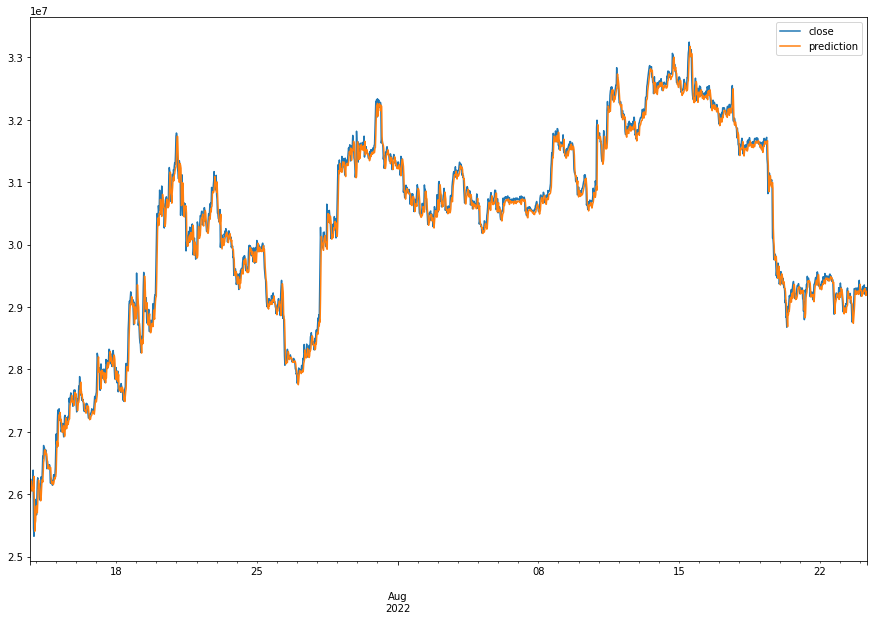

In [ ]:
df_BTC, X_train, X_valid, y_train, y_valid, X_test_scaled, sc, sc1 = make_df(coin_id='BTC', interval='minute30', count=10000, WINDOW_SIZE=20, for_periods=1, TEST_SIZE=2000)
lstm_prediction_BTC = model_train_test(X_train, X_valid, y_train, y_valid, X_test_scaled)
RMSE_BTC, actual_pred_BTC = get_rmse(df_BTC, lstm_prediction_BTC, sc1)
actual_pred_BTC.plot(figsize=(15,10))

In [ ]:
actual_pred_BTC

,close,prediction
2022-07-13 17:30:00,26192000.0,25956426.0
2022-07-13 18:00:00,26243000.0,26083288.0
2022-07-13 18:30:00,26100000.0,26158422.0
2022-07-13 19:00:00,26056000.0,26212450.0
2022-07-13 19:30:00,26083000.0,26129916.0
...,...,...
2022-08-24 06:30:00,29268000.0,29245492.0
2022-08-24 07:00:00,29310000.0,29185708.0
2022-08-24 07:30:00,29251000.0,29206456.0
2022-08-24 08:00:00,29307000.0,29254296.0


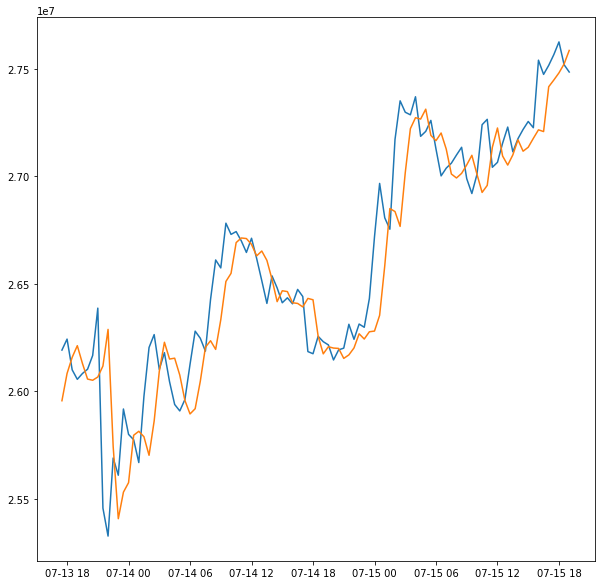

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(actual_pred_BTC.iloc[:100])

In [ ]:
print(RMSE_BTC)

176190.68025465563


There are 6383 samples in the training data
There are 1596 samples in the validation data
There are 1999 samples in the test data
Epoch 1/200
64/64 [==============================] - 5s 32ms/step - loss: 0.0256 - val_loss: 4.0500e-04
Epoch 2/200
64/64 [==============================] - 1s 13ms/step - loss: 1.8669e-04 - val_loss: 1.7134e-04
Epoch 3/200
64/64 [==============================] - 1s 11ms/step - loss: 1.5671e-04 - val_loss: 1.6986e-04
Epoch 4/200
64/64 [==============================] - 0s 8ms/step - loss: 1.5530e-04 - val_loss: 1.6874e-04
Epoch 5/200
64/64 [==============================] - 0s 7ms/step - loss: 1.5544e-04 - val_loss: 1.6959e-04
Epoch 6/200
64/64 [==============================] - 0s 8ms/step - loss: 1.5380e-04 - val_loss: 1.6680e-04
Epoch 7/200
64/64 [==============================] - 1s 9ms/step - loss: 1.5375e-04 - val_loss: 1.6970e-04
Epoch 8/200
64/64 [==============================] - 0s 7ms/step - loss: 1.5024e-04 - val_loss: 1.6469e-04
Epoch 9/200
64/

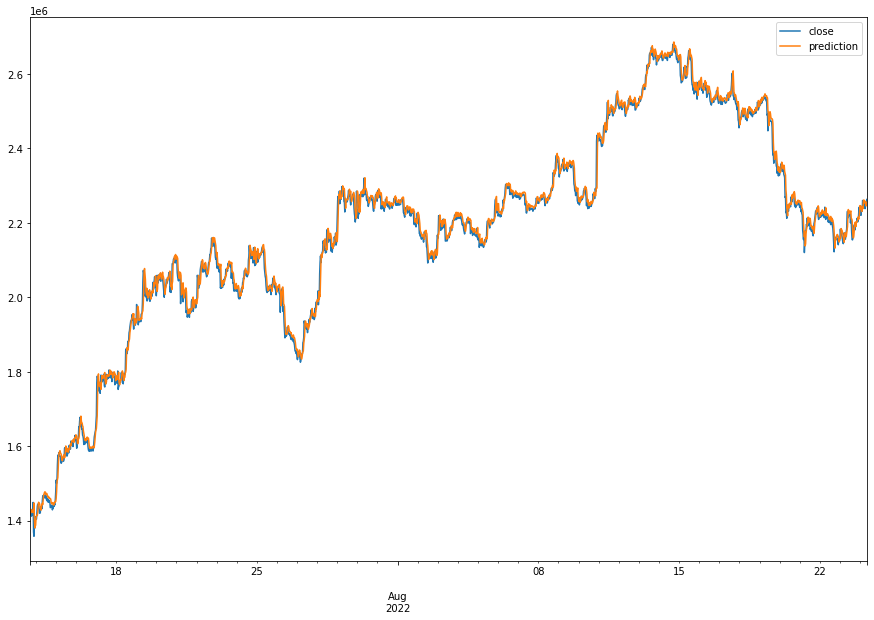

In [ ]:
df_ETH, X_train, X_valid, y_train, y_valid, X_test_scaled, sc, sc1 = make_df(coin_id='ETH', interval='minute30', count=10000, WINDOW_SIZE=20, for_periods=1, TEST_SIZE=2000)
lstm_prediction_ETH = model_train_test(X_train, X_valid, y_train, y_valid, X_test_scaled)
RMSE_ETH, actual_pred_ETH = get_rmse(df_ETH, lstm_prediction_ETH, sc1)
actual_pred_ETH.plot(figsize=(15,10))

In [ ]:
actual_pred_ETH

,close,prediction
2022-07-13 17:30:00,1420000.0,1418191.750
2022-07-13 18:00:00,1422500.0,1422363.500
2022-07-13 18:30:00,1417000.0,1426453.125
2022-07-13 19:00:00,1412000.0,1430064.375
2022-07-13 19:30:00,1414500.0,1428029.625
...,...,...
2022-08-24 06:30:00,2245000.0,2251151.750
2022-08-24 07:00:00,2251000.0,2245313.000
2022-08-24 07:30:00,2249000.0,2248774.750
2022-08-24 08:00:00,2263000.0,2255619.250


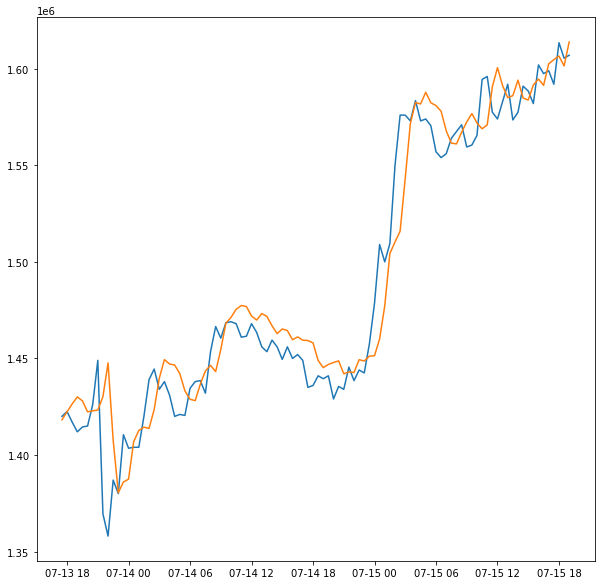

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(actual_pred_ETH.iloc[:100])

In [ ]:
print(RMSE_ETH)

19744.786803670842


# 모듈 상세 실행

In [98]:
df = pyupbit.get_ohlcv(ticker='KRW-'+'BTC', interval='minute30', to='20220824 00:30:00', count=10000)

In [ ]:
df

,open,high,low,close,volume,value
2022-01-27 19:00:00,45010000.0,45290000.0,44999000.0,45120000.0,120.699604,5.449319e+09
2022-01-27 19:30:00,45120000.0,45140000.0,44641000.0,44680000.0,124.149361,5.571149e+09
2022-01-27 20:00:00,44683000.0,45070000.0,44680000.0,45063000.0,105.043347,4.712414e+09
2022-01-27 20:30:00,45063000.0,45198000.0,44964000.0,45085000.0,208.478363,9.400854e+09
2022-01-27 21:00:00,45080000.0,45174000.0,44968000.0,45069000.0,177.910725,8.025123e+09
...,...,...,...,...,...,...
2022-08-24 07:00:00,29258000.0,29363000.0,29244000.0,29310000.0,48.099327,1.409912e+09
2022-08-24 07:30:00,29308000.0,29316000.0,29246000.0,29251000.0,39.139238,1.145906e+09
2022-08-24 08:00:00,29251000.0,29356000.0,29235000.0,29307000.0,37.481807,1.097833e+09
2022-08-24 08:30:00,29307000.0,29334000.0,29271000.0,29307000.0,59.285443,1.737083e+09


In [99]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'value'], dtype='object')

In [ ]:
WINDOW_SIZE = 20
time_steps = 20
all_data = df
for_periods = 1

In [ ]:
# training & test set 만들기
TEST_SIZE = 2000

ts_train = df[:-TEST_SIZE].values
ts_test = df[-TEST_SIZE:].values
ts_train_len = len(ts_train)
ts_test_len = len(ts_test)

In [ ]:
# training 데이터의 samples와 time steps로 원본데이터 슬라이싱하기
X_train_full = []
y_train_full = []
y_train_stacked = []
for i in range(time_steps, ts_train_len - 1):
  X_train_full.append(ts_train[i-time_steps:i,0])
  y_train_full.append(ts_train[i:i+for_periods, 0])
X_train_full, y_train_full = np.array(X_train_full), np.array(y_train_full)

In [ ]:
print(X_train_full.shape)
print(y_train_full.shape)

(7979, 20)
(7979, 1)


In [ ]:
# scale the data
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
sc1 = MinMaxScaler()
X_train_full_scaled = sc.fit_transform(X_train_full)

y_train_full_scaled = sc1.fit_transform(y_train_full)

In [ ]:
# 3차원으로 재구성하기
X_train_full_scaled = np.reshape(X_train_full_scaled, (X_train_full_scaled.shape[0], X_train_full_scaled.shape[1], 1))

In [ ]:
print(X_train_full_scaled.shape)

(7979, 20, 1)


In [ ]:
# Preparing to create X_test
# inputs = sc.transform(df.values)
inputs = df[len(df)-len(ts_test) - time_steps:]
# inputs = inputs.reshape(-1,1)

In [ ]:
inputs = np.array(inputs)

In [ ]:
X_test = []
for i in range(time_steps, ts_test_len + time_steps - for_periods):
  X_test.append(inputs[i-time_steps:i,0])
X_test = np.array(X_test)

# 스케일링
X_test_scaled = sc.transform(X_test)


X_test_scaled = np.reshape(X_test_scaled, (X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

In [ ]:
print(X_train_full_scaled.shape)
print(y_train_full_scaled.shape)
print(X_test_scaled.shape)

(7979, 20, 1)
(7979, 1)
(1999, 20, 1)


In [ ]:
X_train_see = pd.DataFrame(np.reshape(X_train_full, (X_train_full.shape[0], X_train_full.shape[1])))
y_train_see = pd.DataFrame(y_train_full_scaled)
pd.concat([X_train_see, y_train_see], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,0
0,45010000.0,45120000.0,44683000.0,45063000.0,45080000.0,45066000.0,45094000.0,45102000.0,45197000.0,45201000.0,...,45005000.0,44864000.0,44661000.0,44689000.0,44615000.0,44510000.0,44290000.0,44512000.0,44468000.0,0.612181
1,45120000.0,44683000.0,45063000.0,45080000.0,45066000.0,45094000.0,45102000.0,45197000.0,45201000.0,45266000.0,...,44864000.0,44661000.0,44689000.0,44615000.0,44510000.0,44290000.0,44512000.0,44468000.0,44559000.0,0.610519
2,44683000.0,45063000.0,45080000.0,45066000.0,45094000.0,45102000.0,45197000.0,45201000.0,45266000.0,45005000.0,...,44661000.0,44689000.0,44615000.0,44510000.0,44290000.0,44512000.0,44468000.0,44559000.0,44503000.0,0.602065
3,45063000.0,45080000.0,45066000.0,45094000.0,45102000.0,45197000.0,45201000.0,45266000.0,45005000.0,44864000.0,...,44689000.0,44615000.0,44510000.0,44290000.0,44512000.0,44468000.0,44559000.0,44503000.0,44218000.0,0.599513
4,45080000.0,45066000.0,45094000.0,45102000.0,45197000.0,45201000.0,45266000.0,45005000.0,44864000.0,44661000.0,...,44615000.0,44510000.0,44290000.0,44512000.0,44468000.0,44559000.0,44503000.0,44218000.0,44132000.0,0.619864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7974,25768000.0,25832000.0,25939000.0,25906000.0,25935000.0,25748000.0,25860000.0,25730000.0,25757000.0,25723000.0,...,25799000.0,25757000.0,25822000.0,25845000.0,25884000.0,25881000.0,25819000.0,25816000.0,25772000.0,0.055059
7975,25832000.0,25939000.0,25906000.0,25935000.0,25748000.0,25860000.0,25730000.0,25757000.0,25723000.0,25734000.0,...,25757000.0,25822000.0,25845000.0,25884000.0,25881000.0,25819000.0,25816000.0,25772000.0,25779000.0,0.056661
7976,25939000.0,25906000.0,25935000.0,25748000.0,25860000.0,25730000.0,25757000.0,25723000.0,25734000.0,25799000.0,...,25822000.0,25845000.0,25884000.0,25881000.0,25819000.0,25816000.0,25772000.0,25779000.0,25833000.0,0.054763
7977,25906000.0,25935000.0,25748000.0,25860000.0,25730000.0,25757000.0,25723000.0,25734000.0,25799000.0,25757000.0,...,25845000.0,25884000.0,25881000.0,25819000.0,25816000.0,25772000.0,25779000.0,25833000.0,25769000.0,0.056750


In [ ]:
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
pd.DataFrame(X_test_see)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,25860000.0,25730000.0,25757000.0,25723000.0,25734000.0,25799000.0,25757000.0,25822000.0,25845000.0,25884000.0,25881000.0,25819000.0,25816000.0,25772000.0,25779000.0,25833000.0,25769000.0,25836000.0,25807000.0,26057000.0
1,25730000.0,25757000.0,25723000.0,25734000.0,25799000.0,25757000.0,25822000.0,25845000.0,25884000.0,25881000.0,25819000.0,25816000.0,25772000.0,25779000.0,25833000.0,25769000.0,25836000.0,25807000.0,26057000.0,26143000.0
2,25757000.0,25723000.0,25734000.0,25799000.0,25757000.0,25822000.0,25845000.0,25884000.0,25881000.0,25819000.0,25816000.0,25772000.0,25779000.0,25833000.0,25769000.0,25836000.0,25807000.0,26057000.0,26143000.0,26193000.0
3,25723000.0,25734000.0,25799000.0,25757000.0,25822000.0,25845000.0,25884000.0,25881000.0,25819000.0,25816000.0,25772000.0,25779000.0,25833000.0,25769000.0,25836000.0,25807000.0,26057000.0,26143000.0,26193000.0,26245000.0
4,25734000.0,25799000.0,25757000.0,25822000.0,25845000.0,25884000.0,25881000.0,25819000.0,25816000.0,25772000.0,25779000.0,25833000.0,25769000.0,25836000.0,25807000.0,26057000.0,26143000.0,26193000.0,26245000.0,26100000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,29272000.0,29306000.0,29243000.0,29239000.0,29293000.0,29345000.0,29426000.0,29284000.0,29304000.0,29305000.0,29176000.0,29284000.0,29249000.0,29240000.0,29329000.0,29306000.0,29290000.0,29288000.0,29353000.0,29257000.0
1995,29306000.0,29243000.0,29239000.0,29293000.0,29345000.0,29426000.0,29284000.0,29304000.0,29305000.0,29176000.0,29284000.0,29249000.0,29240000.0,29329000.0,29306000.0,29290000.0,29288000.0,29353000.0,29257000.0,29204000.0
1996,29243000.0,29239000.0,29293000.0,29345000.0,29426000.0,29284000.0,29304000.0,29305000.0,29176000.0,29284000.0,29249000.0,29240000.0,29329000.0,29306000.0,29290000.0,29288000.0,29353000.0,29257000.0,29204000.0,29258000.0
1997,29239000.0,29293000.0,29345000.0,29426000.0,29284000.0,29304000.0,29305000.0,29176000.0,29284000.0,29249000.0,29240000.0,29329000.0,29306000.0,29290000.0,29288000.0,29353000.0,29257000.0,29204000.0,29258000.0,29308000.0


In [ ]:
print(X_train_full_scaled.shape)
print(X_test_scaled.shape)

(7979, 20, 1)
(1999, 20, 1)


In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full_scaled, y_train_full_scaled, test_size=0.2)

In [ ]:
y_train

array([[0.57598861],
       [0.07463882],
       [0.10560978],
       ...,
       [0.7574535 ],
       [0.79845145],
       [0.67450829]])

In [ ]:
print('There are '+str(X_train.shape[0]) + ' samples in the training data')
print('There are '+str(X_valid.shape[0]) + ' samples in the validation data')
print('There are '+str(X_test.shape[0]) + ' samples in the test data')

There are 6383 samples in the training data
There are 1596 samples in the validation data
There are 1999 samples in the test data


In [ ]:
my_lstm = Sequential()
my_lstm.add(LSTM(units=50,
                 return_sequences=True,
                 input_shape = (X_train.shape[1], 1),
                 activation='tanh'))
my_lstm.add(LSTM(units=50, activation='tanh'))
my_lstm.add(Dense(units=1))

In [ ]:
# 컴파일링
my_lstm.compile(optimizer = 'adam',
                loss = 'mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=5)

model_path = 'model'
filename = os.path.join(model_path, 'tmp_checkpoint3.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', save_best_only=True, mode='auto')

history = my_lstm.fit(X_train, y_train, 
                                    epochs=200, batch_size=50,
                                    validation_data=(X_valid, y_valid), 
                                    callbacks=[early_stop, checkpoint],
                                    verbose=1)

Epoch 1/200
128/128 [==============================] - 2s 9ms/step - loss: 4.4420e-05 - val_loss: 4.2275e-05
Epoch 2/200
128/128 [==============================] - 1s 7ms/step - loss: 3.3566e-05 - val_loss: 3.6909e-05
Epoch 3/200
128/128 [==============================] - 1s 6ms/step - loss: 3.5289e-05 - val_loss: 4.2827e-05
Epoch 4/200
128/128 [==============================] - 1s 7ms/step - loss: 3.3968e-05 - val_loss: 3.9736e-05
Epoch 5/200
128/128 [==============================] - 1s 7ms/step - loss: 3.6636e-05 - val_loss: 4.6509e-05
Epoch 6/200
128/128 [==============================] - 1s 7ms/step - loss: 4.0170e-05 - val_loss: 5.6893e-05
Epoch 7/200
128/128 [==============================] - 1s 7ms/step - loss: 3.3311e-05 - val_loss: 3.7064e-05


In [ ]:
# loss: 1.2109e-04 - val_loss: 1.1619e-04 => 0.00011619
# loss: 4.9554e-05 - val_loss: 3.8848e-05 => 0.000049554
# loss: 3.6782e-05 - val_loss: 3.9965e-05 => 0.000039965

In [ ]:
lstm_prediction = my_lstm.predict(X_test_scaled)
print(lstm_prediction)

[[0.06435466]
 [0.06695302]
 [0.06842481]
 ...
 [0.15865521]
 [0.1601359 ]
 [0.15848613]]


In [ ]:
lstm_prediction = sc1.inverse_transform(lstm_prediction)

In [ ]:
lstm_prediction.shape

(1999, 1)

In [ ]:
lstm_prediction

array([[26092330.],
       [26179918.],
       [26229532.],
       ...,
       [29271108.],
       [29321022.],
       [29265408.]], dtype=float32)

In [ ]:
actual_pred = pd.DataFrame(columns = ['close', 'prediction'])
actual_pred['close'] = df.iloc[8000:, 3][0:len(lstm_prediction)]

In [ ]:
actual_pred['prediction'] = lstm_prediction[:,0]

In [ ]:
actual_pred

,close,prediction
2022-07-13 17:30:00,26192000.0,26092330.0
2022-07-13 18:00:00,26243000.0,26179918.0
2022-07-13 18:30:00,26100000.0,26229532.0
2022-07-13 19:00:00,26056000.0,26277006.0
2022-07-13 19:30:00,26083000.0,26134164.0
...,...,...
2022-08-24 06:30:00,29268000.0,29270492.0
2022-08-24 07:00:00,29310000.0,29218400.0
2022-08-24 07:30:00,29251000.0,29271108.0
2022-08-24 08:00:00,29307000.0,29321022.0


In [ ]:
from sklearn.metrics import mean_squared_error

RMSE = mean_squared_error(actual_pred['close'].values, actual_pred.iloc[:,1].values)**0.5

In [ ]:
RMSE

168841.36409017167

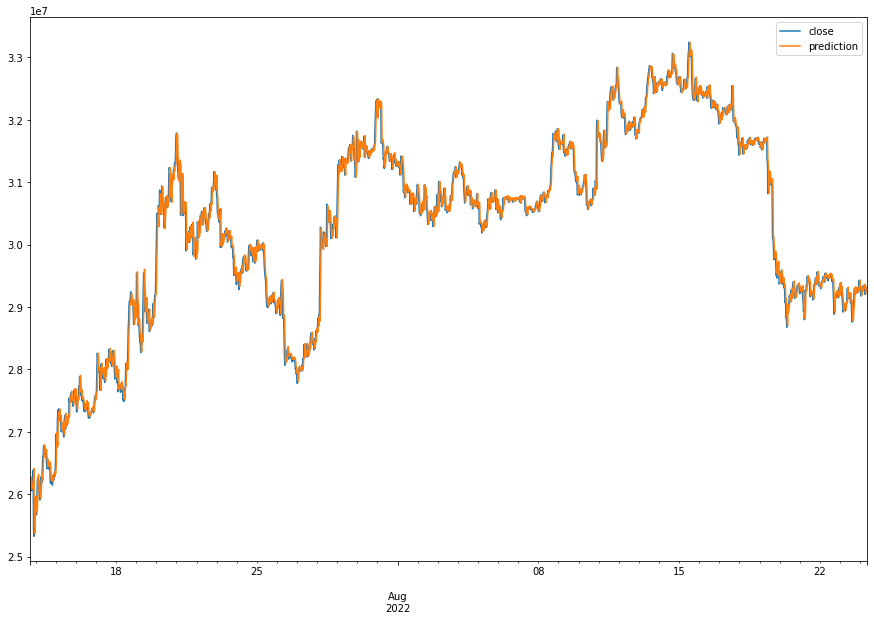

In [ ]:
actual_pred.plot(figsize=(15,10))

1. epochs=50, batch_size=150
  - 275439.52345427184
2. epochs=200, batch_size=150
  - 171843.0667881005
3. epochs=200, batch_size=10
  - 199390.26176509066
4. epochs=200, batch_size=50
  - 169020.27407099277